# **Part II: Analysis**
team member: Shaoying Zheng, Zhongrui Ning, Xiao Pu


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.ticker as mticker

In [11]:
# load data
df = pd.read_csv('./Projectdata/job_company_pair.csv')
df.head()

,job_id,company_id,skill_abr,skill_name,industry_id,max_salary,med_salary,min_salary,pay_period,industry_name,name,company_size,country,employee_count,follower_count,employee_follower_ratio,annual_min_salary,annual_max_salary,annual_med_salary,skill_category
0,921716,2774458.0,MRKT,Marketing,44,20.0,NaN,17.0,HOURLY,Real Estate,Corcoran Sawyer Smith,2.0,US,402,2351,0.170991,35360.0,41600.0,61568.0,Creative
1,921716,2774458.0,SALE,Sales,44,20.0,NaN,17.0,HOURLY,Real Estate,Corcoran Sawyer Smith,2.0,US,402,2351,0.170991,35360.0,41600.0,61568.0,Business
2,10998357,64896719.0,MGMT,Management,32,65000.0,NaN,45000.0,YEARLY,Restaurants,The National Exemplar,1.0,US,15,40,0.375000,45000.0,65000.0,88000.0,Administration
3,10998357,64896719.0,MNFC,Manufacturing,32,65000.0,NaN,45000.0,YEARLY,Restaurants,The National Exemplar,1.0,US,15,40,0.375000,45000.0,65000.0,88000.0,Other
4,23221523,766262.0,OTHR,Other,9,175000.0,NaN,140000.0,YEARLY,Law Practice,"Abrams Fensterman, LLP",2.0,US,222,2427,0.091471,140000.0,175000.0,252000.0,Other


## Descriptive Statistics: 

Firstly, let's check the columns of our data

In [12]:
df.columns

Index(['job_id', 'company_id', 'skill_abr', 'skill_name', 'industry_id',
       'max_salary', 'med_salary', 'min_salary', 'pay_period', 'industry_name',
       'name', 'company_size', 'country', 'employee_count', 'follower_count',
       'employee_follower_ratio', 'annual_min_salary', 'annual_max_salary',
       'annual_med_salary', 'skill_category'],
      dtype='object')

In those columns, `job_id` is the unique value for each job
For the purpose of our analysis, which aiming at job hunting recommendation, we would focus on those following columns: 
- Salary of the job: described by `annual_min_salary`, `annual_med_salary` and `annual_max_salary`
- Skills the job needs: described by `skill_abr`, `skill_name` specifically and `skill_catogory` generally. 
- Size and popularity of the company：described by `employee_count`,`follower_count`, `company_size` and `employee_follower_ratio`
- Industry fields: described by 'industry_name' and 'industry_id'

What are the most common skills listed in job postings across various industries?
What we hope to learn: By identifying the most frequently mentioned skills, we hope to find some "universal" skills in this era.

How do job requirements vary across different industries?
What we hope to learn: We hope to identify the unique skills and qualifications required in different industries, which can help job seekers better understand the job market and make informed decisions.

How could job hunters with different background find suitable jobs?
What we hope to learn: We hope to build a model that can provide job recommendations based on the applicant's background information, such as education, skills, and industry preference. Also, we hope to explore how the model can adapt to incomplete information.
(暂时看一下问题的，之后要删掉)

### Salary description

`annual_min_salary`, `annual_med_salary` and `annual_max_salary` are all numerical float variables, each columns contains the salary description of the job, but not every job have those three kind of salary descriptions (minimum, median and maximum). 

In [13]:
df[['annual_min_salary', 'annual_med_salary', 'annual_max_salary']].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_min_salary,307895.0,128614.925247,3.112777e+06,1.0,37960.0,69800.0,105930.0,499200000.0
annual_med_salary,307895.0,241940.591169,5.256339e+06,1.0,75712.0,130090.4,207200.0,856960000.0
annual_max_salary,307895.0,180584.920583,3.704833e+06,1.0,60250.7,98400.0,151840.0,572000000.0


- We handled the missing values in part 1, and filled all the missing values
- In Part I, we have briefly described the relationship between `annual_med_salary` and occupation type/company size. 
- We didn't use `annual_min_salary` and `annual_max_salary` before. 
- We may use `annual_med_salary` as the prediction variable. 

### Skills description

`skill_abr`, `skill_name` and `skill_category` are all text variables, contains the arbitrary of the skills, the full name of the skills and the category of the skills. 

In [14]:
df. skill_category.value_counts().describe()

count         9.000000
mean      34210.555556
std       40375.064517
min        1066.000000
25%        4552.000000
50%       28084.000000
75%       37179.000000
max      132184.000000
Name: count, dtype: float64

In [15]:
df. skill_category.value_counts().head(10)

skill_category
Other                      132184
Administration              48252
Business                    37179
Technical & Engineering     36144
Finance                     28084
Creative                    15942
Legal & Compliance           4552
Human Resources              4492
Logistics & Operations       1066
Name: count, dtype: int64

## Inferential Statistics

## Graphical Analysis

In [16]:
# First, let's check difference of scale and influence(i.e., number of employee, number of follower and employee-follower ratio) for companies from different industries
# Compute industries with most industries
scale= df.groupby('industry_name')[['employee_count', 'follower_count']].sum()
scale.reset_index(inplace=True)
top_10_scale = scale.sort_values('employee_count',ascending=False).head(10)
top_10_scale

,industry_name,employee_count,follower_count
295,Software Development,2735921688,123308028502
146,IT Services and IT Consulting,900214499,36040992463
29,Banking,679264275,11013292195
107,Financial Services,621679063,15159130878
265,Retail,510721231,7710433210
138,Hospitals and Health Care,447644450,14301106420
309,"Technology, Information and Internet",378823148,41199499094
183,Manufacturing,303425723,20313542172
39,Business Consulting and Services,297442302,9494488933
157,Information Services,295346178,33179466031


We can see top 10 industries with the most job postings. We can see that industries with the most job postings are IT, Finance, and Healthcare. 

In [17]:
top_10_influence = scale.sort_values('follower_count',ascending=False).head(10)
top_10_influence

,industry_name,employee_count,follower_count
295,Software Development,2735921688,123308028502
309,"Technology, Information and Internet",378823148,41199499094
146,IT Services and IT Consulting,900214499,36040992463
157,Information Services,295346178,33179466031
183,Manufacturing,303425723,20313542172
304,Staffing and Recruiting,129189311,16792946067
107,Financial Services,621679063,15159130878
138,Hospitals and Health Care,447644450,14301106420
115,Food and Beverage Services,220402771,14058936153
29,Banking,679264275,11013292195


We can see top 10 industries with the most followers. We can see that industries with the most followers are similar to industries with the most job postings, while adding food and beverage services in.

/var/folders/s0/1w918fdn5qqbxjb9dd551mbw0000gn/T/ipykernel_17997/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
/var/folders/s0/1w918fdn5qqbxjb9dd551mbw0000gn/T/ipykernel_17997/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
/var/folders/s0/1w918fdn5qqbxjb9dd551mbw0000gn/T/ipykernel_17997/3319563960.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")


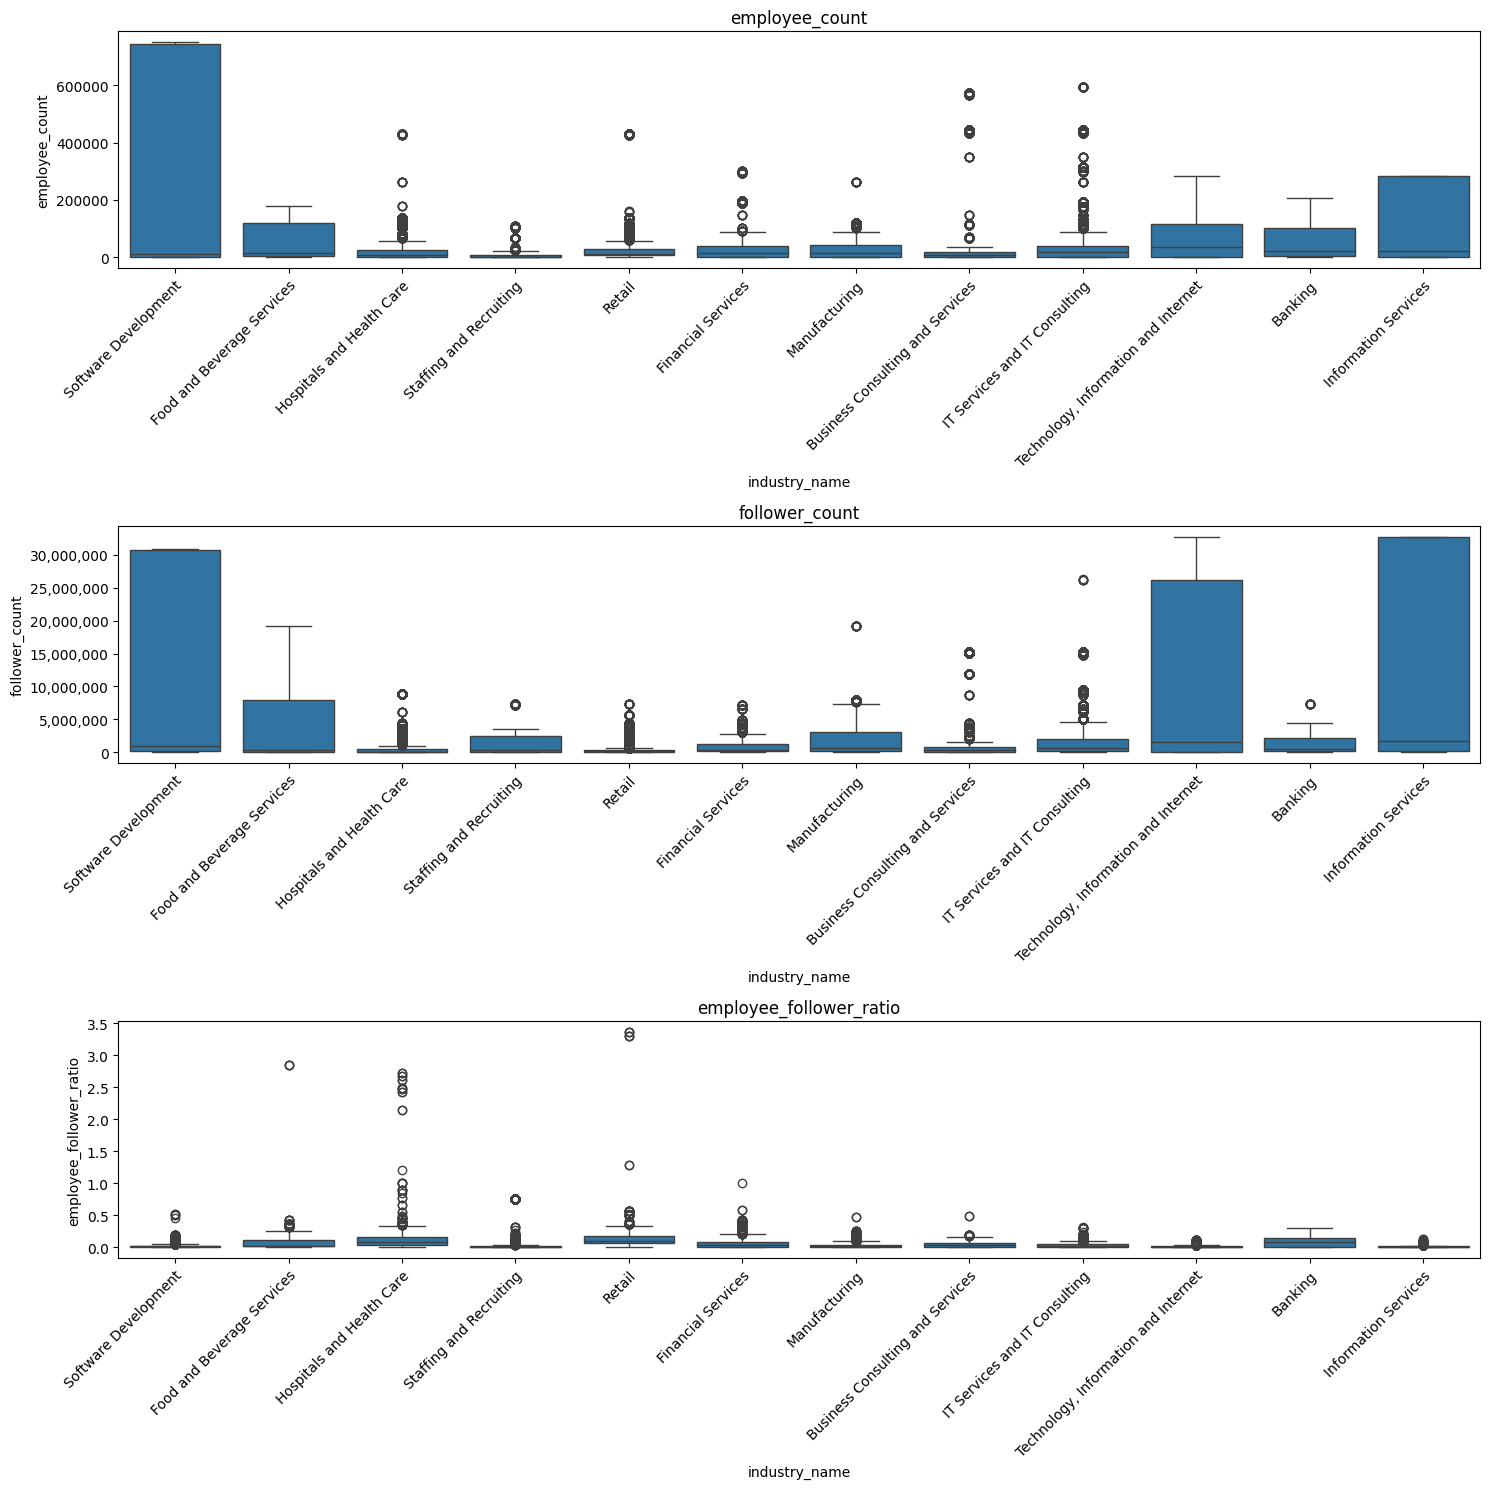

In [18]:
# For different industries within top 10 scale and influence, check the distribution of employee_count, follower_count and employee-follower ratio
top_10_industry = list(set(top_10_scale['industry_name']).union(set(top_10_influence['industry_name'])))
top_10_industry_df = df[df['industry_name'].isin(top_10_industry)]
top_10_industry_df = top_10_industry_df[['industry_name', 'employee_count', 'follower_count', 'employee_follower_ratio']]
# create subsets for each industries and draw boxplot
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for i, col in enumerate(['employee_count', 'follower_count', 'employee_follower_ratio']):
    sns.boxplot(x='industry_name', y=col, data=top_10_industry_df, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right',rotation_mode="anchor")
ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

We can see that software development and Information services industries have the highest overall employee count overall. Which should be the most popular industries that college students should focus on.

## Compartive Analysis

## Multivariate Analysis

## Synthesis

## Reflection